# BERT for *gNER*: Zero-Shot Baseline and Trained Model
In this notebook, we use [Hugging Face](https://huggingface.co/) libraries for [Named Entity Recognition](https://en.wikipedia.org/wiki/Named-entity_recognition) (NER) on [Vorarlberg](https://en.wikipedia.org/wiki/Vorarlberg) real estate deals. Using the highly performant [BERT](https://arxiv.org/abs/1810.04805) transformer architecture, we expect the final results to be in the same league or better than those obtained via [Conditional Random Fields (*CRF*)](https://en.wikipedia.org/wiki/Conditional_random_field) models.

Rough outline:
- Build a *gNER* dataset (actually a `DatasetDict`) with training, validation, and test splits. The test split is intended for final evaluation and shall be used only once, namely for final evaluation.
- Define a BERT model with a custom head for NER and load pretrained parameters from a publicly available [model checkpoint](https://huggingface.co/bert-base-cased).
- Prepare the *gNER* dataset such that its instances can be fed to the model in batches, thus speeding up the training process.
- Train the model. Hyperparameter search would be very usefulbut might be beyond the scope of this notebook.
- Finally, we will evaluate the trained model on the test set and compare the score to our best performing CRF model.

## Building a *gNER* `DatasetDict` for Hugging Face models
Eventually, we want to train a Hugging Face transformer moder on the NER-annotated data from the `annotations2.jsonl`. To this end, we need to bring that data into the correct format, namely a `dataset` or a `DatasetDict`. Here, we want to save all relevant dataset splits (training, validation, and test splits) in a single `DatasetDict`.

### Loading and inspecting the data
Start by loading the data. This and many other steps regarding the data are very similar to the steps in the notebook [CRF-Model_MajorityBaseline_and_HyperparameterSearch](./CRF-Model_MajorityBaseline_and_HyperparameterSearch.ipynb)

In [1]:
import json
import numpy as np
import metrics as mtx
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from datasets import Dataset, DatasetDict, ClassLabel, load_from_disk
from transformers import AutoTokenizer, AutoModelForTokenClassification, DataCollatorForTokenClassification
from transformers import TrainingArguments, Trainer

with open("./annotations2.jsonl") as jsonl_file: # . instead of ..
    lines = jsonl_file.readlines()
annot = [json.loads(line) for line in lines]
print("instances:\n{}".format(len(annot)))
keys = [key for key in annot[0].keys()]
print("\nall keys:\n{}".format(keys))
key_keys = ["text", "spans", "tokens"]
print("\nimportant keys:\n{}".format(key_keys))
print("\nexample text:\n{}".format(annot[0]["text"]))
n_examples = 5
print("\n{} example spans:".format(n_examples))
for span in annot[0]["spans"][:n_examples]:
    print("{}".format(span))
print("\n{} example tokens:".format(n_examples))
for token in annot[0]["tokens"][:n_examples]:
    print("{}".format(token))

instances:
140

all keys:
['text', 'meta', '_input_hash', '_task_hash', 'spans', 'tokens', '_view_id', 'answer', '_timestamp']

important keys:
['text', 'spans', 'tokens']

example text:
DORNBIRN In der Schulgasse in Dornbirn hat eine 71,93 Quadratmeter große Wohnung für einen Quadratmeterpreis von 5533,71 Euro den Besitzer gewechselt. Dieser beinhaltet auch einen Pkw-Abstellplatz. Käufer der Wohnung mit 9,86 Quadratmetern Terrasse ist die ValLiLean Beteiligungs- und Immobilienverwaltungs GmbH. Beim Verkäufer handelt es sich um die Karrenblick Projekt GmbH.  Der Kaufpreis liegt bei 398.040 Euro. Unterzeichnet wurde der Kaufvertrag am 18. September. Die Verbücherung datiert mit Oktober 2020.

5 example spans:
{'text': 'DORNBIRN', 'start': 0, 'end': 8, 'pattern': 2069086582, 'token_start': 0, 'token_end': 0, 'label': 'ORT', 'noWords': 1}
{'start': 16, 'end': 26, 'token_start': 3, 'token_end': 3, 'label': 'STRASSE', 'noWords': 1}
{'text': 'Dornbirn', 'start': 30, 'end': 38, 'pattern': 206

Given a list of span dictionaries (key `"spans"`) and an index referring to the text position within the real estate offering text, return the `"label"` obtained via [prodigy](https://prodi.gy/).

In [2]:
def getLabel(tokenDictList, idx):
    result = "O"
    for dict_i in tokenDictList:
        idx_0, idx_1 = dict_i["start"], dict_i["end"]
        if (idx_0<=idx) and (idx<=idx_1):
            result = dict_i["label"]
    return result 

for j in range(len(annot)): # loop over instances
    a = annot[j]            # instance j
    spans = a["spans"]      # list of annotation dicts
    toks = a["tokens"]      # list of token dicts
    for i in range(len(toks)):                                 # loop over token dicts
        toks[i]["label"] = getLabel(spans, toks[i]["start"])   # assign label from span (if exists, otherwise "O")
    annot[j]["tokens"] = toks

words_n = 3
for i in range(2):
    print("Token dictionaries for the last {} words of instance {}".format(words_n, i))
    ann = annot[i]
    for tok in ann["tokens"][:words_n]:
        print(tok)

Token dictionaries for the last 3 words of instance 0
{'text': 'DORNBIRN', 'start': 0, 'end': 8, 'id': 0, 'ws': True, 'label': 'ORT'}
{'text': 'In', 'start': 9, 'end': 11, 'id': 1, 'ws': True, 'label': 'O'}
{'text': 'der', 'start': 12, 'end': 15, 'id': 2, 'ws': True, 'label': 'O'}
Token dictionaries for the last 3 words of instance 1
{'text': 'FELDKIRCH', 'start': 0, 'end': 9, 'id': 0, 'ws': True, 'label': 'ORT'}
{'text': 'Im', 'start': 10, 'end': 12, 'id': 1, 'ws': True, 'label': 'O'}
{'text': 'Altenreuteweg', 'start': 13, 'end': 26, 'id': 2, 'ws': True, 'label': 'STRASSE'}


### Retrieve the relevant data
Enhance the `"tokens"` dictionaries by labels. The labels are stored in the `spans` dictionaries.

In [3]:
sents=[] 
for annot_i in annot:                  # loop over instances
    toks = annot_i["tokens"]           # get tokens list for instance i
    train_sentence = []
    for tok in toks:                   # loop over token dicts
        if "label" in tok:             # only if the current token has been labelled, ...
            token_element = (tok["text"], tok["label"]) # ... create a "text", "label" pair for this token ...
            train_sentence.append(token_element)        # ... and append it to the list
    sents.append(train_sentence) # append the list for that instances to the list for all instances / sentences

# list of lists of pairs (sets): outer list contains instances and inner list contains (token, label) pairs
sents[:2]

[[('DORNBIRN', 'ORT'),
  ('In', 'O'),
  ('der', 'O'),
  ('Schulgasse', 'STRASSE'),
  ('in', 'O'),
  ('Dornbirn', 'ORT'),
  ('hat', 'O'),
  ('eine', 'O'),
  ('71,93', 'FLAECHE'),
  ('Quadratmeter', 'O'),
  ('große', 'O'),
  ('Wohnung', 'IMMO_TYP'),
  ('für', 'O'),
  ('einen', 'O'),
  ('Quadratmeterpreis', 'O'),
  ('von', 'O'),
  ('5533,71', 'QMPREIS'),
  ('Euro', 'O'),
  ('den', 'O'),
  ('Besitzer', 'O'),
  ('gewechselt', 'O'),
  ('.', 'O'),
  ('Dieser', 'O'),
  ('beinhaltet', 'O'),
  ('auch', 'O'),
  ('einen', 'O'),
  ('Pkw-Abstellplatz', 'O'),
  ('.', 'O'),
  ('Käufer', 'O'),
  ('der', 'O'),
  ('Wohnung', 'O'),
  ('mit', 'O'),
  ('9,86', 'TERRASSENGROESSE'),
  ('Quadratmetern', 'O'),
  ('Terrasse', 'O'),
  ('ist', 'O'),
  ('die', 'O'),
  ('ValLiLean', 'KAEUFER'),
  ('Beteiligungs-', 'KAEUFER'),
  ('und', 'KAEUFER'),
  ('Immobilienverwaltungs', 'KAEUFER'),
  ('GmbH', 'KAEUFER'),
  ('.', 'KAEUFER'),
  ('Beim', 'O'),
  ('Verkäufer', 'O'),
  ('handelt', 'O'),
  ('es', 'O'),
  ('sich', 'O'

From `sents`, which is a list of instances where each instance is a list word-and-label pairs, we create two equally long lists of instances where list 1 contains lists of words (representing the text for an instance) and where list 2 contains lists of labels (representing the NER tags listed in list 1).

In [4]:
# 1. build words / tokens = list of lists of tokens
# 2. build ner_tags / labels = list of lists of labels
words = []
ner_tags = []
for sent_i in sents:
    words_i = []
    ner_tags_i = []
    for item in sent_i:
        words_i.append(item[0])
        ner_tags_i.append(item[1])
    words.append(words_i)
    ner_tags.append(ner_tags_i)

len(words), len(ner_tags)

(140, 140)

### Data splits
We use 80% of the data for development the remaining 20% for final evaluation. The 80% for development are further split into 64% for training and 16% for validation.

Start with the first 80%-20% split.

In [5]:
train_ratio = 0.75
train_test_split = round(0.75*len(words) - 0.5) # -0.5 => floor
idx = [i for i in range(len(words))]
print(idx[:5])
idx_shuffle = shuffle(idx, random_state=0)
print(idx_shuffle[:5])
words_shuffle, ner_tags_shuffle = [words[idx_i] for idx_i in idx_shuffle], [ner_tags[idx_i] for idx_i in idx_shuffle]
words_train, words_test = words_shuffle[:train_test_split], words_shuffle[train_test_split:]
ner_tags_train, ner_tags_test = ner_tags_shuffle[:train_test_split], ner_tags_shuffle[train_test_split:]
len(words_train), len(ner_tags_train), len(words_test), len(ner_tags_test)

[0, 1, 2, 3, 4]
[45, 59, 7, 50, 92]


(104, 104, 36, 36)

Split the 80% part (104 instances) further into training and validation splits. Then, merge all three splits into a `DatasetDict`.

In [6]:
train_dataset = Dataset.from_dict({"words": words_train, "ner_tags": ner_tags_train})
test_dataset = Dataset.from_dict({"words": words_test, "ner_tags": ner_tags_test})
train_valid_split = train_dataset.train_test_split(shuffle=True, seed=42, test_size=0.25)
untokenizedDatasetDict = DatasetDict({
    "train": train_valid_split["train"],
    "valid": train_valid_split["test"],
    "test": test_dataset
})
untokenizedDatasetDict

DatasetDict({
    train: Dataset({
        features: ['words', 'ner_tags'],
        num_rows: 78
    })
    valid: Dataset({
        features: ['words', 'ner_tags'],
        num_rows: 26
    })
    test: Dataset({
        features: ['words', 'ner_tags'],
        num_rows: 36
    })
})

In order to get a list of all `ner_tags` without duplicates, we flatten the equally named list, transform it into a set ($\Rightarrow$ no duplicates) and transform it back into a list. Then, we also sort that list by the leading characters.

In [7]:
# set of labels (as sorted list)
ner_tag_names = sorted(list(set([ner_tag_ij for ner_tags_i in ner_tags for ner_tag_ij in ner_tags_i])))
ner_tag_names

['DATUM_VERBUECHERUNG',
 'DATUM_VERTRAG',
 'FLAECHE',
 'GESAMTPREIS',
 'IMMO_TYP',
 'KAEUFER',
 'O',
 'ORT',
 'QMPREIS',
 'STRASSE',
 'TERRASSENGROESSE',
 'VERKAEUFER']

### Tokenize data and build `DatasetDict`
Select a promising checkpoint from the [model hub](https://huggingface.co/models), instantiate the according tokenizer, and check whether it is a *fast* tokenizer.

In [8]:
# tokenize and adjust labels
checkpoint = "flair/ner-german"  # https://huggingface.co/flair/ner-german (1.41GB)
checkpoint = "fhswf/bert_de_ner" # https://huggingface.co/fhswf/bert_de_ner (419MB)
checkpoint = "bert-base-cased"   # https://huggingface.co/bert-base-cased (416MB)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenizer.is_fast

True

Tokenization turns words into tokens, thus often leading to longer sequences. However, the labels / `"ner_tags"` are not automatically adapted to a modified sequence length. The code below handles this by repeating the NER tag for a word that has been split into multiple tokens as often as is necessary to match the length. Below is only a demonstration with according output.

In [9]:
def align_labels_with_tokens(ner_tags, word_ids):
    #print(word_ids)
    new_labels = []
    previous_label = None
    previous_word_id = None
    for word_id in word_ids:
        # handle word_id==None
        if word_id==None:
            label = -100
        # handle word_id==previous_word_id
        elif word_id==previous_word_id:
            label = previous_label
        # handle word_id!=previous_word_id and word_id!=None
        else:
            text_label = ner_tags[word_id]
            label = ner_tag_names.index(text_label)
        new_labels.append(label)
        previous_label = label
        previous_word_id = word_id
    return new_labels

instance = 0
ner_tags = untokenizedDatasetDict["train"][instance]["ner_tags"]
word_ids = tokenizer(untokenizedDatasetDict["train"][instance]["words"], is_split_into_words=True).word_ids()
aligned_labels = align_labels_with_tokens(ner_tags, word_ids)
inputs = tokenizer(untokenizedDatasetDict["train"][instance]["words"], is_split_into_words=True)
for i, token in enumerate(inputs.tokens()):
    alabel = aligned_labels[i]
    tlabel = ner_tag_names[alabel] if alabel>=0 else "SPECIAL TOKEN"
    print(f"index: {i}\ttoken: {token}\tword_id: {word_ids[i]}\taligned label: {alabel}\ttext label: {tlabel}")
len(inputs.tokens()), len(aligned_labels), len(word_ids)

index: 0	token: [CLS]	word_id: None	aligned label: -100	text label: SPECIAL TOKEN
index: 1	token: L	word_id: 0	aligned label: 7	text label: ORT
index: 2	token: ##US	word_id: 0	aligned label: 7	text label: ORT
index: 3	token: ##TE	word_id: 0	aligned label: 7	text label: ORT
index: 4	token: ##NA	word_id: 0	aligned label: 7	text label: ORT
index: 5	token: ##U	word_id: 0	aligned label: 7	text label: ORT
index: 6	token: In	word_id: 1	aligned label: 6	text label: O
index: 7	token: der	word_id: 2	aligned label: 6	text label: O
index: 8	token: Stein	word_id: 3	aligned label: 9	text label: STRASSE
index: 9	token: ##ack	word_id: 3	aligned label: 9	text label: STRASSE
index: 10	token: ##ers	word_id: 3	aligned label: 9	text label: STRASSE
index: 11	token: ##tra	word_id: 3	aligned label: 9	text label: STRASSE
index: 12	token: ##ße	word_id: 3	aligned label: 9	text label: STRASSE
index: 13	token: 26	word_id: 4	aligned label: 9	text label: STRASSE
index: 14	token: in	word_id: 5	aligned label: 6	text l

(176, 176, 176)

Now, we apply this function to all splits of our dataset.

In [10]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["words"], truncation=True, is_split_into_words=True)
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))
    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs
#
gNerDatasetDict = untokenizedDatasetDict.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=untokenizedDatasetDict["train"].column_names
)
gNerDatasetDict

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 78
    })
    valid: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 26
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 36
    })
})

Add the `ner_tag_names` via the `ClassLabel` class (just as an exercise [&#128521;](https://www.w3schools.com/charsets/ref_emoji_smileys.asp)).

In [11]:
gNerDatasetDict["train"].features["labels"].feature.names = ClassLabel(names=ner_tag_names)
print(gNerDatasetDict["train"].features["labels"].feature.names)
gNerDatasetDict["train"].features["labels"].feature.names.names

ClassLabel(num_classes=12, names=['DATUM_VERBUECHERUNG', 'DATUM_VERTRAG', 'FLAECHE', 'GESAMTPREIS', 'IMMO_TYP', 'KAEUFER', 'O', 'ORT', 'QMPREIS', 'STRASSE', 'TERRASSENGROESSE', 'VERKAEUFER'], id=None)


['DATUM_VERBUECHERUNG',
 'DATUM_VERTRAG',
 'FLAECHE',
 'GESAMTPREIS',
 'IMMO_TYP',
 'KAEUFER',
 'O',
 'ORT',
 'QMPREIS',
 'STRASSE',
 'TERRASSENGROESSE',
 'VERKAEUFER']

Save `gNerDatasetDict` to the local disk.

In [12]:
gNerDatasetDict.save_to_disk("gNERdataset")

Reload the dataset dictionary from disk! However, the `ClassLabel` feature list with the names of the NER tags is not available, anymore!

In [13]:
gNerDataset = load_from_disk("gNERdataset")
gNerDataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 78
    })
    valid: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 26
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 36
    })
})

Trying to access the `ClassLabel` feature would lead to the following error.
```python
gNerDataset["train"].features["labels"].feature.names.names

AttributeError: 'Value' object has no attribute 'names'
```
## Using a [BERT](https://arxiv.org/abs/1810.04805) model from  Hugging Face for evaluation on the *gNER* `DatasetDict`
In order to train a model on the *gNER* `DatasetDict` that we have just built, we need to instantiate a `DataCollatorForTokenClassification`, a model for [token classification](https://huggingface.co/course/chapter7/2?fw=pt), `TrainingArguments`, and a `Trainer`. We also want to avoid using a version of the model that has been overfitted on the training set. But before we get to training, we establish a zero-shot baseline that uses the working model without it having ever seen a single instance of our dataset.

### Building the model
Create `id2label` and `label2id` dictionaries as we will build the model following the Hugging Face course section on [token classification](https://huggingface.co/course/chapter7/2?fw=pt).

In [14]:
id2label = {str(i): label for i, label in enumerate(ner_tag_names)}
label2id = {v: k for k, v in id2label.items()}
id2label, label2id

({'0': 'DATUM_VERBUECHERUNG',
  '1': 'DATUM_VERTRAG',
  '2': 'FLAECHE',
  '3': 'GESAMTPREIS',
  '4': 'IMMO_TYP',
  '5': 'KAEUFER',
  '6': 'O',
  '7': 'ORT',
  '8': 'QMPREIS',
  '9': 'STRASSE',
  '10': 'TERRASSENGROESSE',
  '11': 'VERKAEUFER'},
 {'DATUM_VERBUECHERUNG': '0',
  'DATUM_VERTRAG': '1',
  'FLAECHE': '2',
  'GESAMTPREIS': '3',
  'IMMO_TYP': '4',
  'KAEUFER': '5',
  'O': '6',
  'ORT': '7',
  'QMPREIS': '8',
  'STRASSE': '9',
  'TERRASSENGROESSE': '10',
  'VERKAEUFER': '11'})

Create the model via `AutoModelForTokenClassification.from_pretrained()`, using the same checkpoint as for the tokenizer above, and confirm that the number of labels - implied by `id2label` and `label2id` - matches the number of different labels that occur in our data.

In [15]:
model = AutoModelForTokenClassification.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id
)
model.config.num_labels

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

12

### `DataCollatorForTokenClassification` and macro-averaged $F_1$-scoring
In order to feed batches of square data, i.e. instances of equal length, to our model, we instantiate a `DataCollatorForTokenClassification` that uses our tokenizer.

In [16]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
batch = data_collator([gNerDataset["train"][i] for i in range(2)])
batch["labels"]

tensor([[-100,    7,    7,    7,    7,    7,    6,    6,    9,    9,    9,    9,
            9,    9,    6,    7,    7,    7,    6,    6,    6,    2,    2,    2,
            6,    6,    6,    6,    6,    6,    6,    4,    4,    4,    4,    6,
            6,    6,    6,    6,    6,    6,    6,    6,    6,    8,    8,    8,
            8,    8,    6,    6,    6,    6,    6,    6,    6,    6,    6,    6,
            6,    6,    6,    6,    6,    6,    6,    6,    6,    6,    6,    6,
            6,    6,    6,    6,    6,    6,    6,    6,    6,    6,    6,    6,
            6,    6,    6,    6,    6,    6,    6,    6,    6,    6,    6,    6,
            6,    6,    6,    6,    6,    6,   10,   10,   10,    6,    6,    6,
            6,    6,    6,    6,    6,    6,    6,    6,    6,    6,    6,   11,
           11,   11,   11,   11,   11,    6,    6,    6,    6,    6,    6,    6,
            6,    6,    3,    3,    3,    6,    6,    6,    6,    6,    6,    6,
            6,    6,    6,  

As for the other models that we have applied to *gNER*, we evaluate the performance of BERT via *macro-averaged $F_1$ scoring*. The `Trainer` API will expect a function that receives predictions and returns a dictionary where each key holds a score.

In [17]:
# https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.compute_metrics
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    labels = np.array(labels)
    predictions = np.argmax(logits, axis=-1)
    label_names = ner_tag_names
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels] # list of lists
    true_predictions = [                                                             # list of lists
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    flat_true_labels = [label for true_labels_i in true_labels for label in true_labels_i]                   # list
    flat_true_predictions = [pred for true_predictions_i in true_predictions for pred in true_predictions_i] # list
    macroF1 = f1_score(flat_true_labels, flat_true_predictions, average="macro")
    return {"F1 macro": macroF1}

### Zero-shot baseline
While we have not trained the model, yet, we do already have everything ready to evaluate the model. So let's do that and establish a *zero-shot baseline* by evaluating the model on the validation set without it having ever seen an instance from the training set. [This](https://discuss.huggingface.co/t/using-trainer-at-inference-time/9378) forum post clarifies how inference is performed when using the `Trainer` class.

In [18]:
# https://huggingface.co/transformers/v4.12.5/main_classes/trainer.html#trainingarguments
output_dir = f"gNER_{checkpoint}"
# using the model without further training
# arguments for Trainer
test_args = TrainingArguments(
    output_dir=output_dir,
    do_train=False,
    do_predict=True,
    dataloader_drop_last=False
)
# init trainer
trainer = Trainer(
    model=model, 
    args=test_args,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    tokenizer=tokenizer
)
test_results = trainer.predict(gNerDataset["valid"])
print(f"ZERO-SHOT BASELINE\nmacro averaged F_1 score:\t{test_results.metrics['test_F1 macro']}")

***** Running Prediction *****
  Num examples = 26
  Batch size = 8


ZERO-SHOT BASELINE
macro averaged F_1 score:	0.028653032153239902


This score is ***really*** low! But that's not too surprising as the model has never before seen any data from our dataset. So let's do some training on *gNER*!

## Training and Evaluation
We will use the `Trainer` API to train the model. That means that we will create `TrainingArguments` that specify certain parameters for training, define a `Trainer` instance, and run `Trainer.train()` to launch the training. The following resources have been helpful for getting the training running and loading the best model (based on validation loss) once training has completed:
- Use a trained model for inference:
  - https://discuss.huggingface.co/t/using-trainer-at-inference-time/9378.
  - https://discuss.huggingface.co/t/model-inference-on-tokenized-dataset/14820.
- Save regularly and reload the best model when training is done:
  - https://discuss.huggingface.co/t/save-only-best-model-in-trainer/8442.
  - https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments.load_best_model_at_end.
- Hyperparameter search has not been implemented, here. However, the following links might provide some illumination on that topic:
  - https://discuss.huggingface.co/t/using-hyperparameter-search-in-trainer/785/10.
  - https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Trainer.hyperparameter_search.

Instantiate specific `TrainingArguments`, a specific `Trainer`, and run `Trainer.train()`. While hyperparameter search was not performed - at least not in the fashion of [`RandomizedSearchCV`](https://scikit-learn.org/0.23/modules/generated/sklearn.model_selection.RandomizedSearchCV.html?highlight=randomizedsearchcv#sklearn.model_selection.RandomizedSearchCV) or [`GridSearchCV`](https://scikit-learn.org/0.23/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearchcv#sklearn.model_selection.GridSearchCV) - at least a small number of hyperparameters have been tried out manually (see comments below `trainer.train()`.

In [19]:
# training arguments
train_args = TrainingArguments(
    output_dir,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True, # loads checkpoint with lowest loss on validation set
    learning_rate=5e-5,
    # https://github.com/huggingface/transformers/blob/main/src/transformers/trainer_utils.py#L356
    # "linear" "cosine" "cosine_with_restarts" "polynomial", "constant", "constant_with_warmup"
    lr_scheduler_type="cosine",
    num_train_epochs=15, # 15
    weight_decay=0.01,
    push_to_hub=False
)
trainer = Trainer(
    model=model,
    args=train_args,
    train_dataset=gNerDataset["train"], # "train"
    eval_dataset=gNerDataset["valid"],  # "valid"
    # https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.compute_metrics
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    tokenizer=tokenizer
)
trainer.train()
# learning rate, weight decay, lr_scheduler_type,   valid F1  valid loss
# 5e-5           0.001         linear               0.868     0.207
# 5e-5           0.001         cosine               0.901     0.192
# 5e-5           0.001         cosine_with_restarts 0.895     0.239
# 5e-5           0.001         polynomial           0.885     0.212
# 5e-5           0.001         constant             0.873     0.195
# 5e-5           0.001         constant_with_warmup 0.875     0.193

# 5e-5           0.005         cosine               0.885     0.208
# 5e-5           0.01          cosine               0.917     0.209
# 5e-5           0.03          cosine               0.894     0.189

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 78
  Num Epochs = 15
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 150


Epoch,Training Loss,Validation Loss,F1 macro
1,No log,0.667706,0.489243
2,No log,0.337600,0.763388
3,No log,0.231716,0.864538
4,No log,0.226139,0.857757
5,No log,0.236296,0.879526
6,No log,0.230550,0.900762
7,No log,0.215012,0.892027
8,No log,0.237756,0.903533
9,No log,0.250097,0.893373
10,No log,0.208577,0.917027


***** Running Evaluation *****
  Num examples = 26
  Batch size = 8
Saving model checkpoint to gNER_bert-base-cased/checkpoint-10
Configuration saved in gNER_bert-base-cased/checkpoint-10/config.json
Model weights saved in gNER_bert-base-cased/checkpoint-10/pytorch_model.bin
tokenizer config file saved in gNER_bert-base-cased/checkpoint-10/tokenizer_config.json
Special tokens file saved in gNER_bert-base-cased/checkpoint-10/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 26
  Batch size = 8
Saving model checkpoint to gNER_bert-base-cased/checkpoint-20
Configuration saved in gNER_bert-base-cased/checkpoint-20/config.json
Model weights saved in gNER_bert-base-cased/checkpoint-20/pytorch_model.bin
tokenizer config file saved in gNER_bert-base-cased/checkpoint-20/tokenizer_config.json
Special tokens file saved in gNER_bert-base-cased/checkpoint-20/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 26
  Batch size = 8
Saving model checkpoint to g

TrainOutput(global_step=150, training_loss=0.17458080291748046, metrics={'train_runtime': 59.0766, 'train_samples_per_second': 19.805, 'train_steps_per_second': 2.539, 'total_flos': 129851730281088.0, 'train_loss': 0.17458080291748046, 'epoch': 15.0})

The model has been trained over several epochs. The best model version, namely the one with the lowest loss on the validation set, has been loaded from its checkpoint saved during training. Now, we can evaluate the trained model on the `"test"` split of our *gNER* dataset.

Our metric of choice is the **macro-averaged $F_1$ score**, which we have already employed for the `compute_metrics` argument of the `Trainer` instances above (zero-shot baseline and training).

In [20]:
# https://discuss.huggingface.co/t/using-trainer-at-inference-time/9378/7
test_results = trainer.predict(gNerDataset["test"]) # use "test" instead of "valid" when done with development
test_results.metrics["test_F1 macro"]

***** Running Prediction *****
  Num examples = 36
  Batch size = 8


0.8730272938961597

**Despite using the test split for the first time**, this is - not surprisingly - much better than the *zero-shot baseline* further above and roughly on par with the results for [CRF models](https://stanford.app.box.com/s/5zeuqnkx739rtb103wpdxiedvr63mtrp/file/948454891762).

**Note** that apart from a few manual trials, hyperparameter tuning has hardly been explored. Most likely, the full potential of this BERT model has not been exploited, here.

**Confustion matrices** are shown below and conclude this notebook.

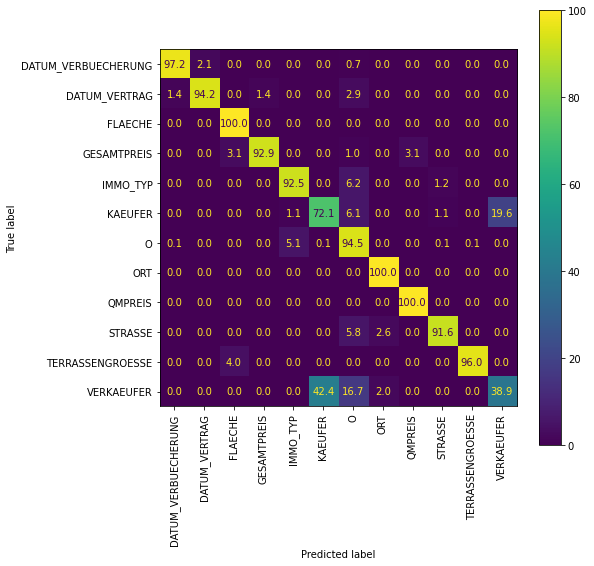

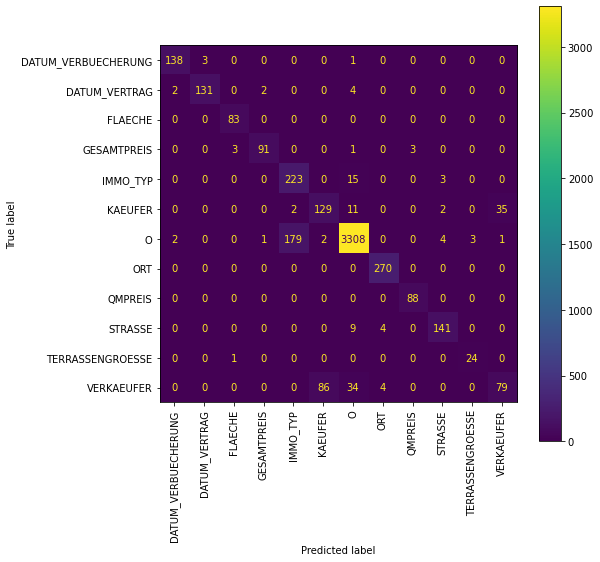

In [21]:
def process_model_output_arrays(labels, preds):
    m = len(labels)
    # make a list of lists (for labels as well as for preds)
    labels_list_of_lists = []
    preds_list_of_lists = []
    for i in range(m):
        label_row, pred_row = labels[i], preds[i]
        # remove all -100 values
        del_idxs = np.where(label_row==-100)
        label_row, pred_row = list(np.delete(label_row, del_idxs)), list(np.delete(pred_row, del_idxs))
        # replace numbers by according strings
        label_row_str = [id2label[str(i)] for i in label_row]
        pred_row_str = [id2label[str(i)] for i in pred_row]
        # build list of lists (for labels as well as for preds)
        labels_list_of_lists.append(label_row_str)
        preds_list_of_lists.append(pred_row_str)
    return labels_list_of_lists, preds_list_of_lists

labels = test_results.label_ids
preds = np.argmax(test_results.predictions, axis=-1)
# produce labels and predictions for the confusion matrix
mtx_labels, mtx_preds = process_model_output_arrays(labels, preds)
# make confusion matrices
mtx.make_confusion_matrix(mtx_labels, mtx_preds, ner_tag_names, size=8)
mtx.make_confusion_matrix(mtx_labels, mtx_preds, ner_tag_names, size=8, percentage=False)

$\checkmark$